# Quality Metrics for the Spectral Matching of Photometric Detectors
## Selection of a new Metric

In [1]:
# Use some packages
import luxpy as lx
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from sklearn.linear_model import LinearRegression
import random
from sigfig import round

strVLambda = '$V(\lambda)$'
strf1p = '$f_{1}^{´}$'
strf1pE = '$f_{1,\mathrm{E}}^{´}$'
strf1pLED = '$f_{1,\mathrm{L}}^{´}$'
strf1pMin = '$f_{1.\mathrm{Min}}^{´}$'
strf1pp = '$f_{1}^{´´}$'
strf1ppR = '$f_{1,\mathrm{R}}^{´´}$'
strf1pBW = '$f_{1,\mathrm{BW}}^{´}$'

str_m_mean = r'$m_{\bar{F}_{i}}$'
str_m_mean_a = r'$m_{\bar{F}_{i}^{a}}$'
str_m_sigma = '$m_{\sigma}$'
str_m_sigma_a = '$m_{\sigma}^{a}$'
str_q_plus = '$F_{i,q+}$'
str_q_plus_a = '$F^{a}_{i,q+}$'
str_m_q_plus = '$m_{q+}$'
str_m_q_plus_a = '$m_{q+}^{a}$'
str_m_q_minus = '$m_{q-}$'
str_m_q_max = '$m_{\mathrm{q,max}}$'
str_m_q_max_a = '$m_{\mathrm{q,max}}^{a}$'
str_m_q_min = '$m_{\mathrm{q,min}}$'


### Demonstration code for article

In [2]:
from empir19nrm02 import _RES, _SPD
from empir19nrm02.f1prime import py_f1PrimeG, py_f1PrimeGlx
from empir19nrm02.tools import plotSelectedSPD, plotYxy, plotHist, plotCorrMatrixSmall, plotHistScales

a1=1
a2=0.7
a3=0.4
a4=0.2
figs_x = 5
figs_y = 5
b_not_for_paper = False
quantil = 0.05
dCutOff=0.003
selected_detector = 73
fig_number = 1
fig_type= '.svg'
table_type= '.csv'

def get_fig_file_name(filename=None, table=False):
    global fig_number
    global fig_type
    if filename is None:
        file_name = r'met\Fig' + str(fig_number) + fig_type
        fig_number+=1
    else:
        if table:
            file_name = r'met\Table' + filename + table_type
        else:
            file_name = r'met\Fig' + filename + fig_type
    return file_name

def save_fig(filename=None):
    return pyplot.savefig( get_fig_file_name(filename), bbox_inches='tight', pad_inches=0)

In [3]:
def SMCFPlotCalc(x_data_i, y_data_i, eins_minus=False, r_sq_calc=False):
    # sort the database for the x values
    y_data_i_sigma = np.std(y_data_i, axis=0)
    if eins_minus:
        y_data_i = np.abs(1-y_data_i)
    y_data_i_mean = np.mean(y_data_i, axis=0)
    y_data_i_min = np.min(y_data_i, axis=0)
    y_data_i_max = np.max(y_data_i, axis=0)
    quantilPlus=np.quantile( y_data_i, 1-quantil/2, axis=0)
    quantilMinus=np.quantile( y_data_i, quantil/2, axis=0)

    # sorting is only necessary for fill_between, not for the regression
    index = np.argsort(x_data_i)
    x_data=x_data_i[index]
    y_data=y_data_i_mean[index]
    y_data_min=y_data_i_min[index]
    y_data_max=y_data_i_max[index]
    qPlus=quantilPlus[index]
    qMinus=quantilMinus[index]
    sigma=y_data_i_sigma[index]

    #regression
    x = x_data.reshape(-1,1)
    lr_model = LinearRegression()
    lr_model.fit(x, y_data)
    y_pred_mean = lr_model.predict(x)
    m_mean=lr_model.coef_[0]
    m_mean_r_sq = lr_model.score(x, y_data)

    lr_model.fit(x, qPlus)
    y_pred_qMax = lr_model.predict(x)
    m_qMax=lr_model.coef_[0]
    m_qMax_r_sq = lr_model.score(x, qPlus)

    lr_model.fit(x, qMinus)
    y_pred_qMin = lr_model.predict(x)
    m_qMin=lr_model.coef_[0]
    r_sq = lr_model.score(x, qMinus)

    # without the first data set (normally zero)
    nonZeros =np.where(x_data != 0)
    smcfSlopeMax = np.zeros(x_data.shape[0])
    smcfSlopeMin = np.zeros(x_data.shape[0])
    if not eins_minus:
        smcfSlopeMax[nonZeros]=(y_data_max[nonZeros]-1)/x_data[nonZeros]
        smcfSlopeMin[nonZeros]=(y_data_min[nonZeros]-1)/x_data[nonZeros]
    else:
        smcfSlopeMax[nonZeros]=(y_data_max[nonZeros])/x_data[nonZeros]
        smcfSlopeMin[nonZeros]=(y_data_min[nonZeros])/x_data[nonZeros]
    smcfSlopeQMax = np.quantile( smcfSlopeMax, 1-quantil)
    smcfSlopeQMin = np.quantile( smcfSlopeMin, quantil)

    lr_model.fit(x, sigma)
    y_pred_sigma = lr_model.predict(x)
    m_sigma=lr_model.coef_[0]
    m_sigma_r_sq = lr_model.score(x, sigma)
    if eins_minus:
        if r_sq_calc:
            return [m_mean, m_mean_r_sq, m_sigma, m_sigma_r_sq, m_qMax, m_qMax_r_sq, smcfSlopeQMax]
        else:
            return [m_mean, m_sigma, m_qMax, smcfSlopeQMax]
    else:
        return [m_mean, m_sigma, m_qMax, m_qMin, smcfSlopeQMax, smcfSlopeQMin]

def SMCFPlot(x_data_i, y_data_i, xlabel, ylabel, title=None, filename=None, ylabel2=None, eins_minus=False, quantil_ind=False):
    # the standard deviation is caculated without the absolut value function
    y_data_i_sigma = np.std(y_data_i, axis=0)
    if eins_minus:
        y_data_i = np.abs(1-y_data_i)
    y_data_i_mean = np.mean(y_data_i, axis=0)
    y_data_i_min = np.min(y_data_i, axis=0)
    y_data_i_max = np.max(y_data_i, axis=0)
    quantilPlus=np.quantile( y_data_i, 1-quantil/2, axis=0)
    quantilMinus=np.quantile( y_data_i, quantil/2, axis=0)

    # sorting is only necessary for fill_between, not for the regression
    index = np.argsort(x_data_i)
    x_data=x_data_i[index]
    y_data=y_data_i_mean[index]
    y_data_min=y_data_i_min[index]
    y_data_max=y_data_i_max[index]
    qPlus=quantilPlus[index]
    qMinus=quantilMinus[index]
    sigma=y_data_i_sigma[index]

    fig, ax1 = pyplot.subplots()
    ax1.plot(x_data, y_data, '*', label=ylabel)
    ax1.fill_between(x_data, y_data_max, y_data_min, alpha=0.2)

    #regression
    x = x_data.reshape(-1,1)
    lr_model = LinearRegression()
    lr_model.fit(x, y_data)
    y_pred_mean = lr_model.predict(x)
    m_mean=lr_model.coef_
    r_sq = lr_model.score(x, y_data)
    if eins_minus:
        ax1.plot(x, y_pred_mean, 'b-', label=str_m_mean_a + '= ' + round( str(m_mean[0]), sigfigs=2) + r' %/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))
    else:
        ax1.plot(x, y_pred_mean, 'b-', label=str_m_mean + '= ' + round( str(m_mean[0]), sigfigs=2) + r' %/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))


    if quantil_ind:
        lr_model.fit(x, qPlus)
        y_pred_qMax = lr_model.predict(x)
        m_qMax=lr_model.coef_
        r_sq = lr_model.score(x, qPlus)
        if eins_minus:
            ax1.plot(x, qPlus, 'gx', label=str_q_plus_a)
            ax1.plot(x, y_pred_qMax, 'g--', label=str_m_q_plus_a + '= ' + round( str(m_qMax[0]), sigfigs=2) + r' %/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))
        else:
            ax1.plot(x, y_pred_qMax, 'g--', label=str_m_q_plus + '= ' + round( str(m_qMax[0]), sigfigs=2) + r' %/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))

        if not eins_minus:
            lr_model.fit(x, qMinus)
            y_pred_qMin = lr_model.predict(x)
            m_qMin=lr_model.coef_
            r_sq = lr_model.score(x, qMinus)
            ax1.plot(x, y_pred_qMin, 'g-.', label=str_m_q_minus + '= ' + round( str(m_qMin[0]), sigfigs=2) + r' %/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))
    else:
        # without the first data set (normally zero)
        if not eins_minus:
            smcfSlopeMax=(y_data_max[1:]-1)/x_data[1:]
            smcfSlopeMin=(y_data_min[1:]-1)/x_data[1:]
        else:
            smcfSlopeMax=(y_data_max[1:])/x_data[1:]
            smcfSlopeMin=(y_data_min[1:])/x_data[1:]
        smcfSlopeQMax = np.quantile( smcfSlopeMax, 1-quantil)
        smcfSlopeQMin = np.quantile( smcfSlopeMin, quantil)
        if not eins_minus:
            ax1.plot( [0,0.1], [1, smcfSlopeQMax*0.1+1], 'b--', label=str_m_q_max + ' ' + round( str(smcfSlopeQMax), sigfigs=2) + r' %/%')
            ax1.plot( [0,0.1], [1, smcfSlopeQMin*0.1+1], 'b-.', label=str_m_q_min + ' ' + round( str(smcfSlopeQMin), sigfigs=2) + r' %/%')
        else:
            ax1.plot( [0,0.1], [0, smcfSlopeQMax*0.1], 'b--', label=str_m_q_max_a + ' '  + round( str(smcfSlopeQMax), sigfigs=2) + r' %/%')

    if ylabel2 is not None:
        ax2 = ax1.twinx()
        ax2.plot(x_data, sigma, 'ro', label=ylabel2)
        ax2.set_ylabel(ylabel2)
        ax2.spines['right'].set_color('red')
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis='y', colors='red')
        lr_model.fit(x, sigma)
        y_pred_sigma = lr_model.predict(x)
        m_sigma=lr_model.coef_
        r_sq = lr_model.score(x, sigma)
        ax2.plot(x, y_pred_sigma, 'r-', label=str_m_sigma + '= '+ round( str(m_sigma[0]), sigfigs=2) + r' 1/%' + ' $r^{2}=$ '+ round( str(r_sq), sigfigs=2))

    ax1.set_xlabel( xlabel)
    ax1.set_ylabel(ylabel)
    if not eins_minus:
        ax1.set_ylim([0.95, 1.05])
    else:
        ax1.set_ylim([0.0, 0.05])

    pyplot.title(title)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    #fig.legend(lines, labels, bbox_to_anchor=(0, 0, 1, 0), loc="upper left", mode="expand", ncol=2)
    fig.legend(lines, labels)
    if filename is not None:
        pyplot.savefig(filename)


## Read some detector and spd data from the empir19nrm02 package
<li>every entry (spectral responsivity, SPD is a row in the matrix, the first row is containing the wavelength scale)</li>
<li>For all data files in this project the first (sometimes also the second) data set(s) are used for referecne
calculations (e.g. for detectors the first one is V(Lambda) and for SPDs the first is standard illuminant A
and the second one sometimes illuminant L41)</li>

### Select the source data for simulation (change the entries in res_data (True/False for the required data sets)
### Detector Data
<li>VLDetectors: Current Collection</li>
<li>CIES025_VLDetectors: Collection from CIES025:2015</li>

In [4]:
res_data = { 'VLDetectors': True,
              'CIES025_VLDetectors': False
              }
detector_start_reading = True
detector_names = ''
print('Detector data base:')
for detector, enable in res_data.items():
    print('Name:', detector )
    print('    Size:', _RES[detector]['S']['data'].shape[0]-1 )
    print('    Use:', enable )
    if enable:
        detector_names = detector_names + detector + ' '
        if detector_start_reading:
            vldetectorsTemp=_RES[detector]['S']['data'].copy()
            wl_start = vldetectorsTemp[0].copy()
            detector_start_reading=False
        else:
            data_to_append = _RES[detector]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='linear')
            vldetectorsTemp = np.vstack( (vldetectorsTemp, interpolated_data[1:]))

print( 'Detectors for the Simulation:')
print( '    Detectors:', detector_names)
print( '    Number of detectors:', vldetectorsTemp.shape[0]-1)

Detector data base:
Name: VLDetectors
    Size: 127
    Use: True
Name: CIES025_VLDetectors
    Size: 121
    Use: False
Detectors for the Simulation:
    Detectors: VLDetectors 
    Number of detectors: 127


## Test the data analyses for different wavelength resolutions based on the same data set.
<li>bInterpol=False means using the original wavelength resolution of the data set (probably 5nm)</li>
<li>bInterpol=True  means using the wavelength resolution of 1nm by interpolation of the original data to that resolution</li>

In [5]:
bInterpol = False
if bInterpol:
    wl_interpol = lx.getwlr([380,780,1])
    vldetectors=lx.cie_interp(vldetectorsTemp, wl_interpol, negative_values_allowed=True, kind='S')
else:
    vldetectors=vldetectorsTemp

print( vldetectorsTemp.shape)
print( vldetectors.shape)

(128, 81)
(128, 81)


### Select the SPD data for simulation (change the entries in spd_data (True/False for the required data sets)
### SPD Data
<li>BB: Collection of Blackbody SPDs </li>
<li>PTLED':  Collection of PT White LEDs</li>
<li>CIES025_PTLED':  Collection of PT White LEDs used in CIES025:2015</li>
<li>OSRAM_PTLED':  Collection of PT White LEDs from OSRAM</li>
<li>RGBLED':  Collection of RGB White LEDs</li>
<li>CIES025_RGBLED':  Collection of RGB White LEDs used in CIES025:2015</li>
<li>PHOTOLED':  Collection of PT White LEDs from the PhotoLED-Project</li>
<li>MONOLED':  Collection of Monochrome LEDs</li>
<li>OSRAM_MONOLED':  Collection of Monochrome LEDs from OSRAM</li>

In [6]:
spd_data = {'BB': False,
            'PTLED': False,
            'CIES025_PTLED': False,
            'OSRAM_PTLED': False,
            'RGBLED':  False,
            'CIES025_RGBLED':  False,
            'PHOTOLED':  True,
            'MONOLED':  False,
            'OSRAM_MONOLED':  False}


spd_start_reading = True
spd_names = ''
print('SPD data base:')
for spd, enable in spd_data.items():
    print('Name:', spd, '\t\t\t', 'Size:', _SPD[spd]['S']['data'].shape[0]-1, '\t\t', 'Use:', enable)
    if enable:
        spd_names = spd_names + spd + ' '
        if spd_start_reading:
            spectra=_SPD[spd]['S']['data'].copy()
            wl_start = spectra[0].copy()
            spd_start_reading=False
        else:
            data_to_append = _SPD[spd]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='S')
            spectra = np.vstack( (spectra, interpolated_data))

print( '\nSPDs for the Simulation:')
print( '    SPD:', spd_names)
print( '    Number of spds:', spectra.shape[0]-1)


SPD data base:
Name: BB 			 Size: 55 		 Use: False
Name: PTLED 			 Size: 229 		 Use: False
Name: CIES025_PTLED 			 Size: 228 		 Use: False
Name: OSRAM_PTLED 			 Size: 137 		 Use: False
Name: RGBLED 			 Size: 98 		 Use: False
Name: CIES025_RGBLED 			 Size: 97 		 Use: False
Name: PHOTOLED 			 Size: 1496 		 Use: True
Name: MONOLED 			 Size: 288 		 Use: False
Name: OSRAM_MONOLED 			 Size: 260 		 Use: False

SPDs for the Simulation:
    SPD: PHOTOLED 
    Number of spds: 1496


### Calculating all the different $f_{1}^{'}$ values.

### Sort the detectors on their $f_{1}^{'}$ values to make the visualization easier

In [7]:
#f1pT=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
#vldetectors[1:]=vldetectors[np.argsort(f1pT)+1]

# What is the topic here?

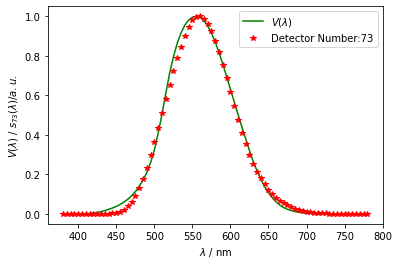

In [8]:
fig0, ax0 = pyplot.subplots()
strNumber = str(selected_detector)
ax0.plot(vldetectors[0], vldetectors[1],'g-', label=strVLambda)
ax0.plot(vldetectors[0], vldetectors[selected_detector],'r*', label=r'Detector Number:' + strNumber)
ax0.legend()
if b_not_for_paper:
    pyplot.title('Selected relative spectral responsivity and target function')
pyplot.ylabel(strVLambda + r' / $s_{' + strNumber + '}(\lambda) / a.u.$')
pyplot.xlabel('$\lambda$ / nm')
save_fig(filename='SampleDetector')

### Get some statistical data from the detectors

In [9]:
#f1pA=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='A', cieobs='1931_2', s_target_index=2)
#f1pE=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='E', cieobs='1931_2', s_target_index=2)
#f1pLED=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='LED_B3', cieobs='1931_2', s_target_index=2)
f1pA=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
f1pE=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
f1pLED=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
f1pAFMin=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
f1pp=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
f1ppR=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
f1pBW20nm=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

### Get all $f_{1}^{´}$ values (standard evaluation, weighting with illuminant A, target function $V(\lambda)$)

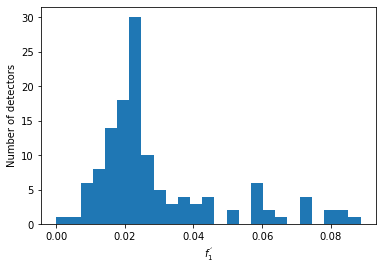

In [10]:
if b_not_for_paper:
    plotHist( f1pA, xLabel=strf1p, yLabel='Number of detectors', bins=25, title='Histogram of $f_{1}^{´}$  Data:' + detector_names)
else:
    plotHist( f1pA, xLabel=strf1p, yLabel='Number of detectors', bins=25, title=None)
save_fig(filename='Histf1p')


### Let's have a look for the differences $f_{1}^{´}$-$f_{1,\mathrm{L}}^{´}$ and  $f_{1}^{´}$-$f_{1}^{*}$ over $f_{1}^{´}$
#### BTW:  $f_{1}^{*}$ is using the weighting with Standard illuminant E (no weighting at all)

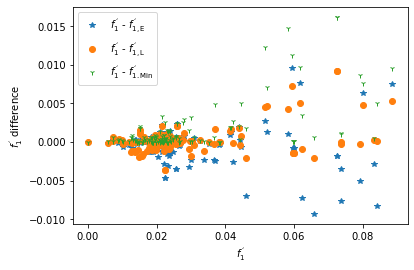

In [11]:
pyplot.plot(f1pA, f1pA-f1pE, '*', label=strf1p + ' - ' + strf1pE)
pyplot.plot(f1pA, f1pA-f1pLED, 'o', label=strf1p + ' - ' + strf1pLED)
pyplot.plot(f1pA, f1pA-f1pAFMin, '1', label=strf1p + ' - ' + strf1pMin)
#pyplot.plot(f1pA, f1pA-f1ppR, '2', label=strf1p + ' - ' + strf1ppR)
#pyplot.plot(f1pA, f1pA-f1pBW20nm, '3', label=strf1p + ' - ' + strf1pBW)
pyplot.xlabel(strf1p)
pyplot.ylabel(strf1p + ' difference')
pyplot.legend()
save_fig(filename='f1pDiff')

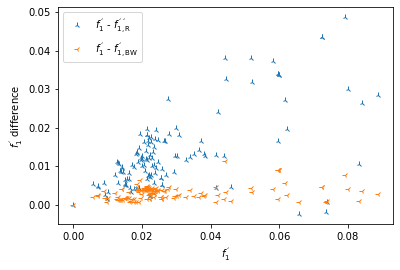

In [12]:
#pyplot.plot(f1pA, f1pA-f1pE, '*', label=strf1p + ' - ' + strf1pE)
#pyplot.plot(f1pA, f1pA-f1pLED, 'o', label=strf1p + ' - ' + strf1pLED)
#pyplot.plot(f1pA, f1pA-f1pAFMin, '1', label=strf1p + ' - ' + strf1pMin)
pyplot.plot(f1pA, f1pA-f1ppR, '2', label=strf1p + ' - ' + strf1ppR)
pyplot.plot(f1pA, f1pA-f1pBW20nm, '3', label=strf1p + ' - ' + strf1pBW)
pyplot.xlabel(strf1p)
pyplot.ylabel(strf1p + ' difference')
pyplot.legend()
save_fig(filename='f1pDiffNew')

# Explanation of the deltaVector

<ipython-input-13-8c555514b5b2>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  [f1Array[1,i], detaVectorArray[1,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)


#:	 [73]
$f_{1}^{´}$ $:	$ [5.9713e-02]
$f_{1,\mathrm{R}}^{´´}$ $:	$ [2.5723e-02]
$f_{1,\mathrm{BW}}^{´}$ $:	$ [5.0759e-02]


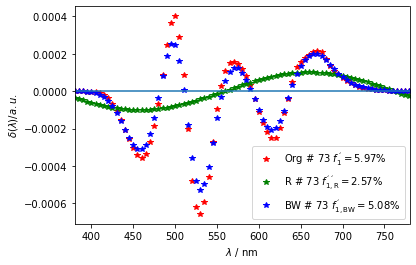

In [13]:
vlDetectorNumber = vldetectors.shape[0]-1
vlDetectorListNumber = 1
if vlDetectorListNumber < vlDetectorNumber:
    detectorList = [random.randint(1, vlDetectorNumber) for p in range(1, vlDetectorListNumber+1)]
else:
    detectorList = range(1, vlDetectorNumber+1)
    vlDetectorListNumber = vlDetectorNumber

detectorList[0]=selected_detector

f1Array = np.zeros( (3, vlDetectorListNumber))
detaVectorArray = np.zeros( (3, vlDetectorListNumber, vldetectors.shape[1]))

for i in range(0, vlDetectorListNumber):
    [f1Array[0,i], detaVectorArray[0,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    [f1Array[1,i], detaVectorArray[1,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
    [f1Array[2,i], detaVectorArray[2,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

    fig, ax = pyplot.subplots()
    strLabel = 'Org # ' + str(detectorList[i]) + ' ' + strf1p + '$=$' + round(str(f1Array[0,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[0,i],'r*', label=strLabel)
    strLabel = 'R # ' + str(detectorList[i]) + ' ' + strf1ppR + '$=$' + round(str(f1Array[1,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[1,i],'g*', label=strLabel)
    strLabel = 'BW # ' + str(detectorList[i]) + ' ' + strf1pBW + '$=$' + round(str(f1Array[2,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[2,i],'b*', label=strLabel)
    ax.set_xlim(left=380, right=780)
    ax.axhline(0)
    ax.legend()
    if b_not_for_paper:
        pyplot.title('Comparison of $\delta (\lambda)$ functions for different ' + strf1p + ' calculations')
    pyplot.ylabel('$\delta(\lambda) / a.u.$')
    pyplot.xlabel('$\lambda$ / nm')
    save_fig(filename='DeltaFunctions')


print('#:\t', detectorList)
print(strf1p, '$:\t$', f1Array[0])
print(strf1ppR, '$:\t$', f1Array[1])
print(strf1pBW, '$:\t$', f1Array[2])

<ipython-input-14-36c8070e9ee1>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  [f1Array[1,i], detaVectorArray[1,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
<ipython-input-14-36c8070e9ee1>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  [f1Array[2,i], detaVectorArray[2,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-4*dCutOff, dBandWidth=0.)
<ipython-input-14-36c8070e9ee1>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  [f1Array[3,i], detaVectorArray[3,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-5*dCutOff, dBandWidth=0.)


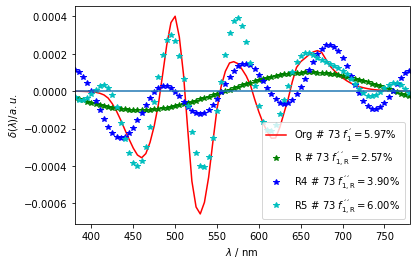

In [14]:
f1Array = np.zeros( (4, vlDetectorListNumber))
detaVectorArray = np.zeros( (4, vlDetectorListNumber, vldetectors.shape[1]))

for i in range(0, vlDetectorListNumber):
    [f1Array[0,i], detaVectorArray[0,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    [f1Array[1,i], detaVectorArray[1,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
    [f1Array[2,i], detaVectorArray[2,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-4*dCutOff, dBandWidth=0.)
    [f1Array[3,i], detaVectorArray[3,i]] = py_f1PrimeG(vldetectors[0], vldetectors[detectorList[i]], strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-5*dCutOff, dBandWidth=0.)

    fig, ax = pyplot.subplots()
    strLabel = 'Org # ' + str(detectorList[i]) + ' ' + strf1p + '$=$' + round(str(f1Array[0,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[0,i],'r-', label=strLabel)
    strLabel = 'R # ' + str(detectorList[i]) + ' ' + strf1ppR + '$=$' + round(str(f1Array[1,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[1,i],'g*', label=strLabel)
    strLabel = 'R4 # ' + str(detectorList[i]) + ' ' + strf1ppR + '$=$' + round(str(f1Array[2,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[2,i],'b*', label=strLabel)
    strLabel = 'R5 # ' + str(detectorList[i]) + ' ' + strf1ppR + '$=$' + round(str(f1Array[3,i]*100), decimals=2) + r'%'
    ax.plot(vldetectors[0], detaVectorArray[3,i],'c*', label=strLabel)
    ax.set_xlim(left=380, right=780)
    ax.axhline(0)
    ax.legend()
    if b_not_for_paper:
        pyplot.title('Comparison of $\delta (\lambda)$ functions for different cutoff frequencies')
    pyplot.ylabel('$\delta(\lambda) / a.u.$')
    pyplot.xlabel('$\lambda$ / nm')
    save_fig(filename='DeltaFunctionsCutOff')

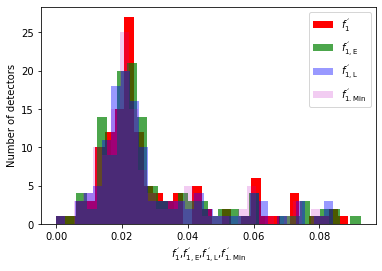

In [15]:
hBins = 30

fig, ax = pyplot.subplots()
ax.set_xlabel(strf1p + ',' + strf1pE + ','  + strf1pLED + ',' + strf1pMin)
ax.set_ylabel('Number of detectors')
ax.hist(f1pA.flatten(),  bins=hBins, alpha = a1, log=False, label=strf1p, color = 'r')
ax.hist(f1pE.flatten(),  bins=hBins, alpha = a2, log=False, label=strf1pE, color = 'g')
ax.hist(f1pLED.flatten(),  bins=hBins, alpha = a3, log=False, label=strf1pLED, color = 'b')
ax.hist(f1pAFMin.flatten(), bins=hBins, alpha = a4, log=False, label=strf1pMin, color = 'm')
ax.legend()
save_fig(filename='Hist_Comp_f1pf1pEf1pLEDf1pMin')

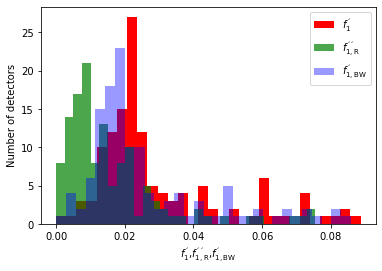

In [16]:
fig, ax = pyplot.subplots()
ax.set_xlabel(strf1p + ',' + strf1ppR   + ','  + strf1pBW)
ax.set_ylabel('Number of detectors')
ax.hist(f1pA.flatten(),  bins=hBins, alpha = a1, log=False, label=strf1p, color = 'r')
ax.hist(f1ppR.flatten(),  bins=hBins, alpha = a2, log=False, label=strf1ppR, color = 'g')
ax.hist(f1pBW20nm.flatten(),  bins=hBins, alpha = a3, log=False, label=strf1pBW, color = 'b')
ax.legend()
save_fig(filename='Hist_Comp_f1pf1ppRf1pBW')

### Calculating the correlation between all the different $f_{1}^{'}$ values

In [17]:
# Combine the results in a vector
f1pEval = np.vstack(( f1pA, f1pE, f1pLED, f1pAFMin, f1pp, f1ppR, f1pBW20nm))
f1pEvalCorr = np.corrcoef(f1pEval)

In [18]:
np.savetxt('f1pEval.csv', f1pEval, delimiter=';')
np.savetxt('specTestl.csv', vldetectors, delimiter=';')

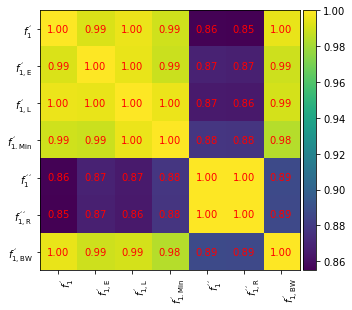

In [19]:
x_label_list = [ strf1p, strf1pE, strf1pLED, strf1pMin, strf1pp, strf1ppR, strf1pBW]
if b_not_for_paper:
    plotCorrMatrixSmall(f1pEvalCorr, x_label_list, title='$f_{1}^{´}$ Correlations', fileName=None, with_values=True)
else:
    plotCorrMatrixSmall(f1pEvalCorr, x_label_list, title=None, fileName=None, with_values=True)
save_fig(filename='f1pCorrelations')

In [20]:
def calc_data_from_spectra_detectors(detectorsLoc, spectraLoc, eins_minus=False, r_sq_calc=True):
    b_f1pA=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    b_f1pE=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    b_f1pLED=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    b_f1pAFMin=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    b_f1pp=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
    b_f1ppR=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
    b_f1pBW20nm=py_f1PrimeGlx(detectorsLoc, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

    b_SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectraLoc, detectorsLoc, S_C='A')
    b_SMCFE=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectraLoc, detectorsLoc, S_C='E')
    b_SMCFLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectraLoc, detectorsLoc, S_C='LED_B3')

    b_meanA0=np.mean(abs(b_SMCF-1), axis=0)
    b_stdA0_1=np.std(b_SMCF, axis=0)

    b_meanLED=np.mean(abs(b_SMCFLED-1), axis=0)
    b_stdLED_1=np.std(b_SMCFLED, axis=0)

    qPlusA=np.quantile( abs(b_SMCF-1), 1-quantil/2, axis=0)
    qPlusLED=np.quantile( abs(b_SMCFLED-1), 1-quantil/2, axis=0)

    # Combine the results in a vector
    b_eval = np.vstack(( b_f1pA, b_f1pE, b_f1pLED, b_f1pAFMin, b_f1pp, b_f1ppR, b_f1pBW20nm, b_meanA0, b_stdA0_1, qPlusA, b_meanLED, b_stdLED_1, qPlusLED))
    b_corr = np.corrcoef(b_eval)

    v_m_Dataf1p=SMCFPlotCalc(b_f1pA, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    v_m_Dataf1pE=SMCFPlotCalc(b_f1pE, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    v_m_Dataf1pLED=SMCFPlotCalc(b_f1pLED, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    v_m_Dataf1pAFMin=SMCFPlotCalc(b_f1pAFMin, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    v_m_Dataf1ppR=SMCFPlotCalc(b_f1ppR, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    v_m_Dataf1pBW20nm=SMCFPlotCalc(b_f1pBW20nm, b_SMCFLED, eins_minus=eins_minus, r_sq_calc=r_sq_calc)
    return [b_corr, v_m_Dataf1p,v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pAFMin, v_m_Dataf1ppR, v_m_Dataf1pBW20nm]

# SMCF
# Calculate the SMCF based on Illuminant A and SMCFLED based on Illuminant L41

In [21]:
[res, v_m_Dataf1pA, _, v_m_Dataf1pLED, _, v_m_Dataf1ppR, _]=calc_data_from_spectra_detectors( vldetectors, spectra, eins_minus=True)

SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectra, vldetectors, S_C='A')
SMCFE=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectra, vldetectors, S_C='E')
SMCFLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectra, vldetectors, S_C='LED_B3')
spectraRGB = _SPD['CIES025_RGBLED']['S']['data'].copy()
SMCFLED_RGB=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectraRGB, vldetectors, S_C='LED_B3')

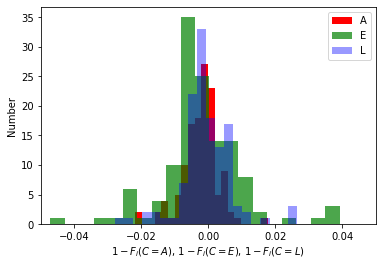

In [22]:
fig, ax = pyplot.subplots()
ax.set_xlabel(r'$1-F_{i}(C=A)$' + ', ' + r'$1-F_{i}(C=E)$' + ', ' + r'$1-F_{i}(C=L)$')
ax.set_ylabel('Number')
ax.hist(1-SMCF[selected_detector],  bins=20, alpha = a1, log=False, label='A', color = 'r')
ax.hist(1-SMCFE[selected_detector],  bins=20, alpha = a2, log=False, label='E', color = 'g')
ax.hist(1-SMCFLED[selected_detector], bins=20, alpha = a3, log=False, label='L', color = 'b')
ax.set_xlim([-0.05,0.05])
ax.legend()
save_fig(filename='Hist_Comp_SMCF1_A_E_LED')

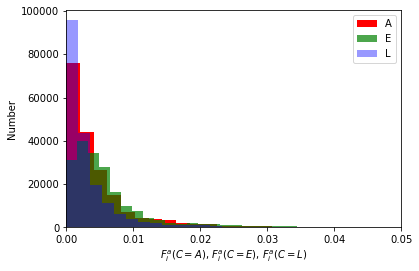

In [23]:
fig, ax = pyplot.subplots()
ax.set_xlabel(r'$F^{a}_{i}(C=A)$' + ', ' + r'$F^{a}_{i}(C=E)$' + ', ' + r'$F^{a}_{i}(C=L)$')
ax.set_ylabel('Number')
ax.hist(np.abs(1-SMCF).flatten(),  bins=100, alpha = a1, log=False, label='A', color = 'r')
ax.hist(np.abs(1-SMCFE).flatten(),  bins=100, alpha = a2, log=False, label='E', color = 'g')
ax.hist(np.abs(1-SMCFLED).flatten(), bins=100, alpha = a3, log=False, label='L', color = 'b')
ax.set_xlim([0,0.05])
ax.legend()
save_fig(filename='Hist_Comp_SMCFA_E_LED')


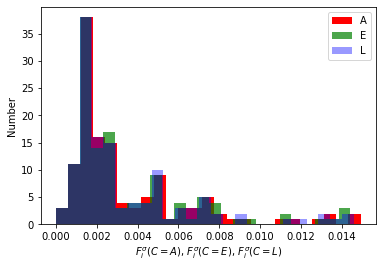

In [24]:
fig, ax = pyplot.subplots()
ax.set_xlabel(r'$F^{\sigma}_{i}(C=A)$' + ', ' + r'$F^{\sigma}_{i}(C=E)$' + ', ' + r'$F^{\sigma}_{i}(C=L)$')
ax.set_ylabel('Number')
ax.hist(np.std((1-SMCF), axis=0).flatten(),  bins=25, alpha = a1, log=False, label='A', color = 'r')
ax.hist(np.std((1-SMCFE), axis=0).flatten(),  bins=25, alpha = a2, log=False, label='E', color = 'g')
ax.hist(np.std((1-SMCFLED), axis=0).flatten(), bins=25, alpha = a3, log=False, label='L', color = 'b')
#ax.set_xlim([0,0.05])
ax.legend()
save_fig(filename='Hist_Comp_StdSMCFA_E_LED')

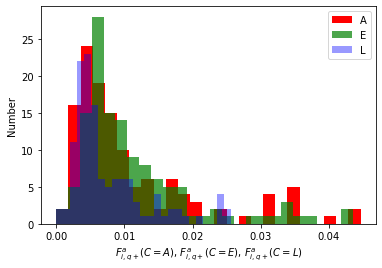

In [25]:
h_qPlusA=np.quantile( abs(SMCF-1), 1-quantil/2, axis=0)
h_qPlusE=np.quantile( abs(SMCFE-1), 1-quantil/2, axis=0)
h_qPlusLED=np.quantile( abs(SMCFLED-1), 1-quantil/2, axis=0)

fig, ax = pyplot.subplots()
ax.set_xlabel(r'$F_{i,q+}^{a}(C=A)$' + ', ' + r'$F_{i,q+}^{a}(C=E)$' + ', ' + r'$F_{i,q+}^{a}(C=L)$')
ax.set_ylabel('Number')
ax.hist(h_qPlusA.flatten(),  bins=25, alpha = a1, log=False, label='A', color = 'r')
ax.hist(h_qPlusE.flatten(),  bins=25, alpha = a2, log=False, label='E', color = 'g')
ax.hist(h_qPlusLED.flatten(), bins=25, alpha = a3, log=False, label='L', color = 'b')
#ax.set_xlim([0,0.05])
ax.legend()
save_fig(filename='Hist_Comp_qPlusA_E_LED')


# Correlation
#### Let's have a look at all correlations (between all the characteristics calculated before)

In [26]:
#    b_eval = np.vstack(( b_f1pA, b_f1pE, b_f1pLED, b_f1pAFMin, b_f1pp, b_f1ppR, b_f1pBW20nm,
#    b_meanA0, b_stdA0_1, qPlusA, b_meanLED, b_stdLED_1, qPlusLED))

x_label_list = [strf1p,strf1pE, strf1pLED, strf1pMin, strf1pp, strf1ppR, strf1pBW, \
                r'$\bar{F}^{a}_{i}(C=A)$', r'$F^{\sigma}_{i}(C=A)$', '$F_{i,q+}^{a}(C=A)$',\
                r'$\bar{F}^{a}_{i}(C=L)$', r'$F^{\sigma}_{i}(C=L)$', '$F_{i,q+}^{a}(C=L)$']

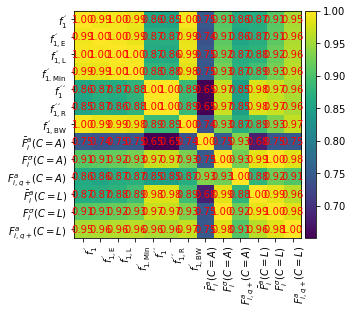

In [27]:
plotCorrMatrixSmall(res, x_label_list, with_values=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='f1pCorrelations2_CIES025')
else:
    save_fig(filename='f1pCorrelations2_PhotoLED')


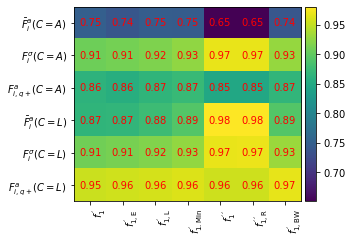

In [28]:
plotCorrMatrixSmall(res, x_label_list, iRaws=7, iCols=6, with_values=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='f1pCorrelations2P_CIES025')
else:
    save_fig(filename='f1pCorrelations2P_PhotoLED')

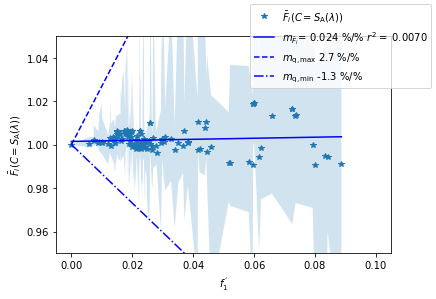

In [29]:
SMCFPlot( f1pA, SMCF, strf1p, r'$\bar{F}_{i}(C=S_{\mathrm{A}}(\lambda))$', \
              quantil_ind=False )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlots')
else:
    save_fig(filename='PhotoLEDQuantilePlots')

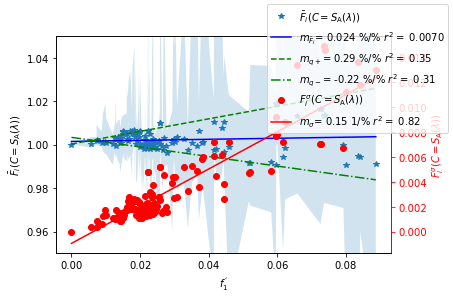

In [30]:
SMCFPlot( f1pA, SMCF, strf1p, r'$\bar{F}_{i}(C=S_{\mathrm{A}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{A}}(\lambda))$', quantil_ind=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAll')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAll')


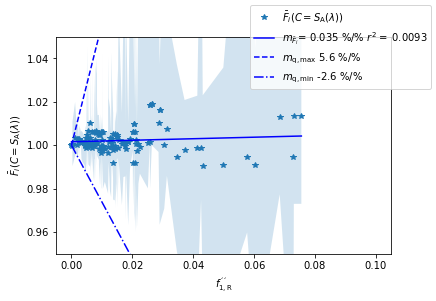

In [31]:
SMCFPlot( f1ppR, SMCF, strf1ppR, r'$\bar{F}_{i}(C=S_{\mathrm{A}}(\lambda))$', \
              quantil_ind=False )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsf1ppR')
else:
    save_fig(filename='PhotoLEDQuantilePlotsf1ppR')

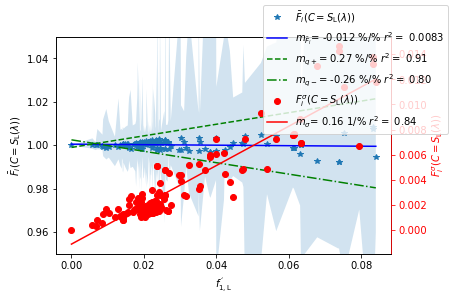

In [32]:
SMCFPlot( f1pLED, SMCFLED, strf1pLED, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1pLED')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1pLED')

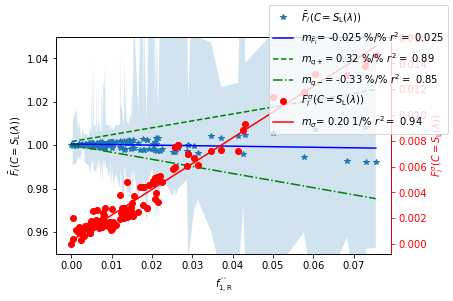

In [33]:
SMCFPlot( f1ppR, SMCFLED, strf1ppR, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1ppR')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1ppR')

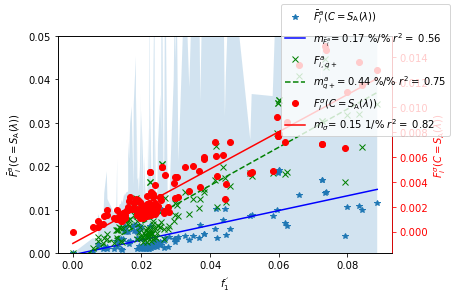

In [34]:
SMCFPlot( f1pA, SMCF, strf1p, r'$\bar{F}_{i}^{a}(C=S_{\mathrm{A}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{A}}(\lambda))$', quantil_ind=True, eins_minus=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlots1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlots1Minus')

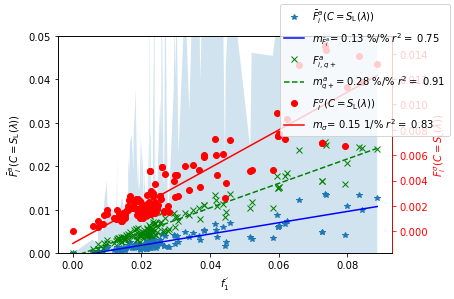

In [35]:
SMCFPlot( f1pA, SMCFLED, strf1p, r'$\bar{F}_{i}^{a}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsf1p1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsf1p1Minus')

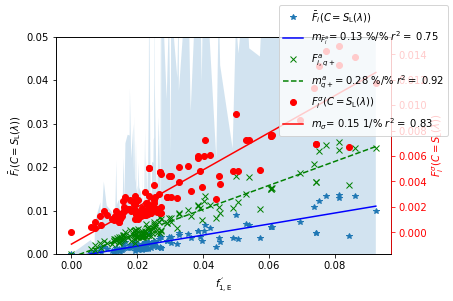

In [36]:
SMCFPlot( f1pE, SMCFLED, strf1pE, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1pE1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1pE1Minus')

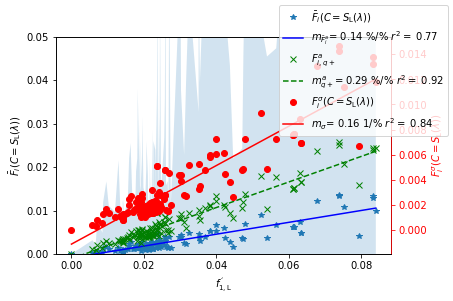

In [37]:
SMCFPlot( f1pLED, SMCFLED, strf1pLED, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1pLED1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1pLED1Minus')


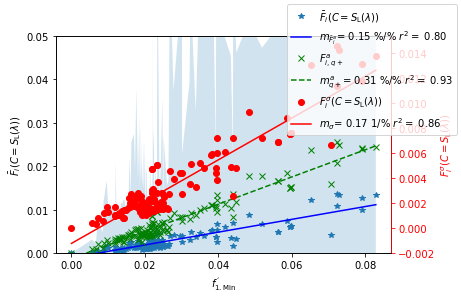

In [38]:
SMCFPlot( f1pAFMin, SMCFLED, strf1pMin, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1pMin1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1pMin1Minus')

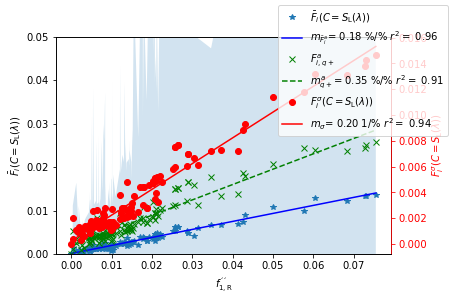

In [39]:
SMCFPlot( f1ppR, SMCFLED, strf1ppR, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1ppR1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1ppR1Minus')

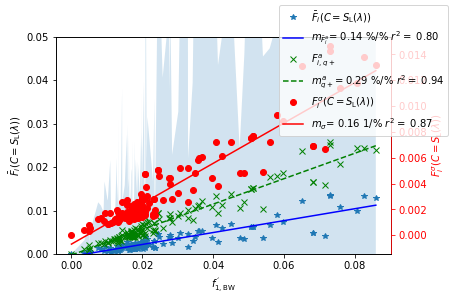

In [40]:
SMCFPlot( f1pBW20nm, SMCFLED, strf1pBW, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True)

if spd_data['CIES025_PTLED']:
    save_fig(filename='CIES025QuantilePlotsAllf1pBW1Minus')
else:
    save_fig(filename='PhotoLEDQuantilePlotsAllf1pBW1Minus')


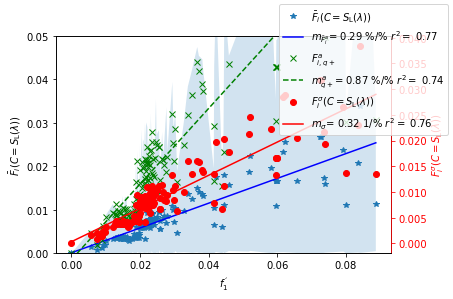

In [41]:
SMCFPlot( f1pA, SMCFLED_RGB, strf1p, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1p1Minus')

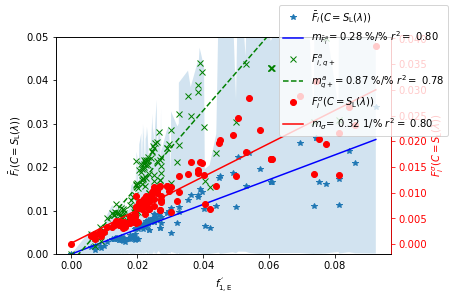

In [42]:
SMCFPlot( f1pE, SMCFLED_RGB, strf1pE, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1pE1Minus')

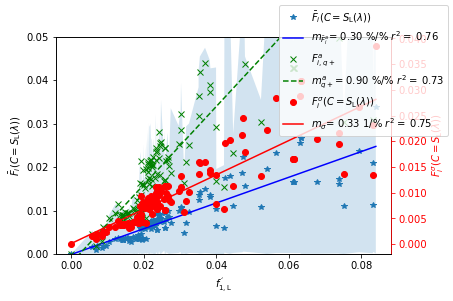

In [43]:
SMCFPlot( f1pLED, SMCFLED_RGB, strf1pLED, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1pLED1Minus')

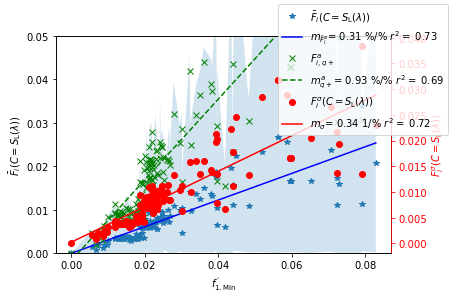

In [44]:
SMCFPlot( f1pAFMin, SMCFLED_RGB, strf1pMin, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1pMin1Minus')


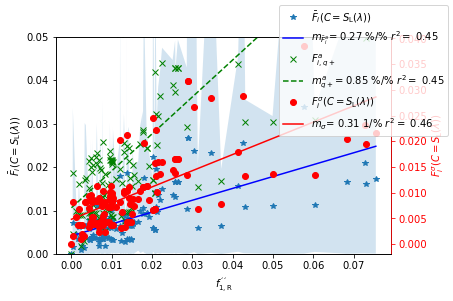

In [45]:
SMCFPlot( f1ppR, SMCFLED_RGB, strf1ppR, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1ppR1Minus')

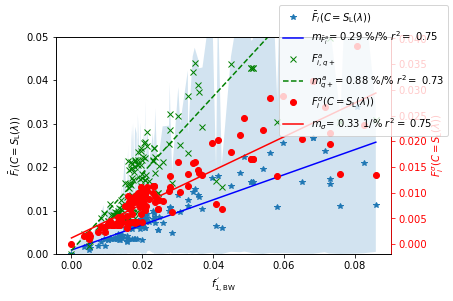

In [46]:
SMCFPlot( f1pBW20nm, SMCFLED_RGB, strf1pBW, r'$\bar{F}_{i}(C=S_{\mathrm{L}}(\lambda))$', \
              ylabel2=r'$F^{\sigma}_{i}(C=S_{\mathrm{L}}(\lambda))$', quantil_ind=True, eins_minus=True )
save_fig(filename='CIES025RGBQuantilePlotsAllf1pBW1Minus')

# All data into a table

## CIES025 PT LED

In [47]:
import pandas as pd

def makeTable( spectraLoc, filename):
    #[_, v_m_Dataf1p,v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pAFMin, v_m_Dataf1ppR, v_m_Dataf1pBW20nm]= \
    data = calc_data_from_spectra_detectors( vldetectors, spectraLoc, eins_minus=True, r_sq_calc=True)

    strNames=['', 'f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
    f1pTable = pd.DataFrame()
    for i in range(1,7):
        v_m_current = data[i]
        #strName = 'f1p'
        df = pd.DataFrame( { \
            'N': [i], \
            'Name': strNames[i], \
            'm_mean': v_m_current[0], 'm_mean_r_sq': v_m_current[1], \
            'm_sigma': v_m_current[2], 'm_sigma_r_sq': v_m_current[3], \
            'm_qMax': v_m_current[4], 'm_qMax_r_sq': v_m_current[5], \
            'smcfSlopeQMax': v_m_current[6] } )
        f1pTable = f1pTable.append( df)

    print( f1pTable)
    f1pTable.to_csv(get_fig_file_name(filename, table=True), sep=';',  decimal=",")


strData = 'CIES025_PTLED'
spectraTmp = _SPD[strData]['S']['data'].copy()
makeTable( spectraTmp, strData)


   N       Name    m_mean  m_mean_r_sq   m_sigma  m_sigma_r_sq    m_qMax  \
0  1        f1p  0.122848     0.814231  0.131976      0.874490  0.256171   
0  2       f1pE  0.120922     0.827228  0.128764      0.872891  0.250401   
0  3     f1pLED  0.129035     0.830908  0.137986      0.884213  0.268486   
0  4     f1pMin  0.138502     0.852565  0.146915      0.892692  0.285854   
0  5      f1ppR  0.167030     0.958052  0.170222      0.925952  0.329900   
0  6  f1pBW20nm  0.129064     0.855477  0.138193      0.912689  0.267678   

   m_qMax_r_sq  smcfSlopeQMax  
0     0.846448       0.487176  
0     0.848044       0.488029  
0     0.860026       0.484344  
0     0.868225       0.512925  
0     0.893508       2.302847  
0     0.879741       0.540755  


## CIES025 RGB White LED

In [48]:
strData = 'CIES025_RGBLED'
spectraTmp = _SPD[strData]['S']['data'].copy()
makeTable( spectraTmp, strData)

   N       Name    m_mean  m_mean_r_sq   m_sigma  m_sigma_r_sq    m_qMax  \
0  1        f1p  0.285092     0.766452  0.323013      0.764640  0.869658   
0  2       f1pE  0.284658     0.801251  0.322338      0.798447  0.872872   
0  3     f1pLED  0.295358     0.760920  0.333241      0.752766  0.898725   
0  4     f1pMin  0.306019     0.727470  0.344923      0.718236  0.927448   
0  5      f1ppR  0.272669     0.446252  0.314754      0.462118  0.849659   
0  6  f1pBW20nm  0.288578     0.747534  0.327876      0.749939  0.884959   

   m_qMax_r_sq  smcfSlopeQMax  
0     0.740803       1.402564  
0     0.782555       1.358525  
0     0.731791       1.426356  
0     0.694048       1.502889  
0     0.450079       5.910586  
0     0.730201       1.606185  


## PhotoLED PT LED

In [49]:
strData = 'PHOTOLED'
spectraTmp = _SPD[strData]['S']['data'].copy()
makeTable( spectraTmp, strData)

   N       Name    m_mean  m_mean_r_sq   m_sigma  m_sigma_r_sq    m_qMax  \
0  1        f1p  0.129702     0.751693  0.148948      0.827479  0.281173   
0  2       f1pE  0.126808     0.753440  0.145933      0.832921  0.275363   
0  3     f1pLED  0.136364     0.768547  0.156346      0.843320  0.293893   
0  4     f1pMin  0.147159     0.797116  0.167353      0.860525  0.312629   
0  5      f1ppR  0.183934     0.962201  0.199218      0.942198  0.352773   
0  6  f1pBW20nm  0.136924     0.797439  0.156259      0.866905  0.292361   

   m_qMax_r_sq  smcfSlopeQMax  
0     0.910909       2.447028  
0     0.916102       2.202272  
0     0.920517       2.415887  
0     0.927659       2.471028  
0     0.912666       4.383970  
0     0.937465       2.604805  


# Bootstrap

C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 nan nan
1 0.7603053163569785 0.0
2 0.7717359548469694 0.01143063848999093
3 0.7866018591694619 0.023002098893584507
4 0.7819902670638339 0.021462123855265414
5 0.7829526375501485 0.01929255908672357
6 0.7918026872780842 0.026491242534661667
7 0.7933262138454055 0.02480841787043149
8 0.79937967671017 0.028196387821231336
9 0.7924137565141018 0.03308914133760078
10 0.7931614142967358 0.03147114672923673
11 0.7998850926753888 0.03677597334214483
12 0.8051373262058338 0.03928373359248426
13 0.8109225954154495 0.0427333032735583
14 0.8074089697830875 0.04308351570585074
15 0.8041780091959915 0.04334271402384742
16 0.8046207549637314 0.04200142006517437
17 0.8047814411464431 0.04075243165121146
18 0.8075213246609382 0.04118391131741453
19 0.8046811099269591 0.04185747388121818
20 0.8014459793589166 0.043165970854185394
21 0.8016987858783937 0.0421408429147789
22 0.8025355516639081 0.04135013753830079
23 0.8019024248793443 0.04055011665528638
24 0.7996111740874513 0.041189137606819526
25 0.

F:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


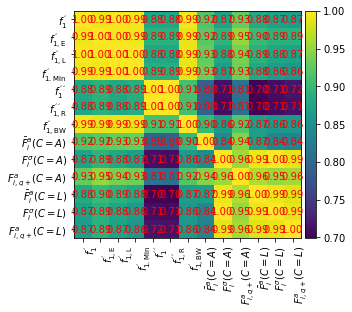

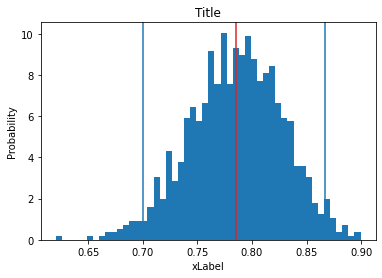

In [59]:
b_runs = 1000
b_use_detector = True
b_use_spectra = True

b_eins_minus = True

strData = 'PHOTOLED'
strData = 'CIES025_RGBLED'
spectraTmp = _SPD[strData]['S']['data'].copy()

vlDetectorNumber = vldetectors.shape[0]-1
b_detector_number=vlDetectorNumber
spectraNumber = spectraTmp.shape[0]-1
b_spectra_number=spectraNumber

# store the simulation results
[res, v_m_Dataf1pA, v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pMin, v_m_Dataf1ppR, v_m_Dataf1pBW]=\
    calc_data_from_spectra_detectors( vldetectors, spectraTmp, eins_minus=b_eins_minus, r_sq_calc=False)
resArray = np.zeros( (b_runs, res.shape[0], res.shape[1]))

v_m_Data_Array=np.zeros((b_runs, 6, np.array(v_m_Dataf1pA).shape[0]))

iRow=7
iCol=4

for i in range(0, b_runs):
    if b_use_detector:
        b_detectorList = np.hstack((0,[random.randint(1, vlDetectorNumber) for p in range(1, b_detector_number+1)]))
    else:
        b_detectorList = range(0, b_detector_number+1)
    if b_use_spectra:
        b_spectraList = np.hstack((0,[random.randint(1, spectraNumber) for p in range(1, b_spectra_number+1)]))
    else:
        b_spectraList = range(0, b_spectra_number+1)

    b_detectors = vldetectors[b_detectorList]
    b_spectra = spectraTmp[b_spectraList]

    [res, v_m_Dataf1pA, v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pMin, v_m_Dataf1ppR, v_m_Dataf1pBW]=\
        calc_data_from_spectra_detectors( b_detectors, b_spectra, eins_minus=b_eins_minus, r_sq_calc=False)
    resArray[i]=res.copy()
    v_m_Data_Array[i, 0]=np.array(v_m_Dataf1pA).copy()
    v_m_Data_Array[i, 1]=np.array(v_m_Dataf1pE).copy()
    v_m_Data_Array[i, 2]=np.array(v_m_Dataf1pLED).copy()
    v_m_Data_Array[i, 3]=np.array(v_m_Dataf1pMin).copy()
    v_m_Data_Array[i, 4]=np.array(v_m_Dataf1ppR).copy()
    v_m_Data_Array[i, 5]=np.array(v_m_Dataf1pBW).copy()
    print(i, np.mean(resArray[:i, iRow, iCol]), np.std(resArray[:i, iRow, iCol]))

plotCorrMatrixSmall(res, x_label_list)
plotHistScales( resArray[:,iRow,iCol], )

[[2.8589e-01 3.2078e-01 8.5331e-01 1.3515e+00]
 [2.8531e-01 3.1990e-01 8.5471e-01 1.3039e+00]
 [2.9629e-01 3.3110e-01 8.8207e-01 1.3728e+00]
 [3.0763e-01 3.4347e-01 9.1272e-01 1.4644e+00]
 [2.7756e-01 3.1676e-01 8.4041e-01 6.3291e+00]
 [2.8976e-01 3.2591e-01 8.6831e-01 1.5421e+00]]
[[3.4641e-02 3.5823e-02 1.0825e-01 6.4062e-02]
 [3.0890e-02 3.1167e-02 9.5777e-02 6.7588e-02]
 [3.5053e-02 3.6399e-02 1.0967e-01 6.6850e-02]
 [3.8196e-02 4.0023e-02 1.1947e-01 6.0668e-02]
 [4.8692e-02 5.0388e-02 1.4497e-01 1.7942e+00]
 [3.7240e-02 3.8150e-02 1.1476e-01 1.1247e-01]]


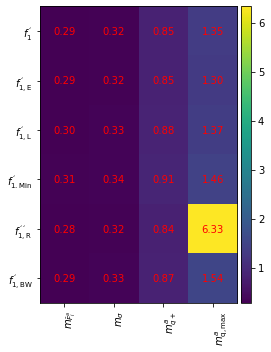

In [60]:
if b_eins_minus:
    v_m_x_list = [str_m_mean_a, str_m_sigma, str_m_q_plus_a, str_m_q_max_a]
else:
    v_m_x_list = [str_m_mean, str_m_sigma, str_m_q_plus, str_m_q_minus, str_m_q_max, str_m_q_min]
v_m_y_list = [strf1p, strf1pE, strf1pLED, strf1pMin, strf1ppR, strf1pBW]
v_m_DataMean=np.mean(v_m_Data_Array, axis=0)
v_m_DataStd=np.std(v_m_Data_Array, axis=0)
print( v_m_DataMean)
print( v_m_DataStd)
plotCorrMatrixSmall(v_m_DataMean, v_m_x_list, y_data_labels=v_m_y_list)
save_fig(filename='BS_mCorrImage'+strData)

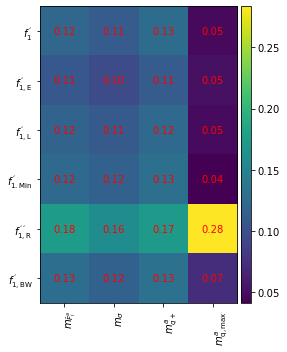

In [61]:
plotCorrMatrixSmall(v_m_DataStd/v_m_DataMean, v_m_x_list, y_data_labels=v_m_y_list, fileName='BS_stdCorrImage')
save_fig(filename='BS_stdCorrImage'+strData)

In [62]:
strNames=['f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
bTable = pd.DataFrame()
sRel= v_m_DataStd/v_m_DataMean
for i in range(0,6):
    #strName = 'f1p'
    df = pd.DataFrame( { \
        'N': [i], \
        'Name': strNames[i], \
        'm_mean': v_m_DataMean[i][0], 'u(m_mean)': sRel[i][0], \
        'm_sigma': v_m_DataMean[i][1], 'u(m_sigma)': sRel[i][1], \
        'm_qMax': v_m_DataMean[i][2], 'u(qMax)': sRel[i][2], \
        'smcfSlopeQMax': v_m_DataMean[i][3],  'u(smcfSlopeQMax)': sRel[i][3]} )
    bTable = bTable.append( df)

print( bTable)
bTable.to_csv(get_fig_file_name('bTable'+strData, table=True), sep=';',  decimal=",")

   N       Name    m_mean  u(m_mean)   m_sigma  u(m_sigma)    m_qMax  \
0  0        f1p  0.285887   0.121169  0.320778    0.111676  0.853309   
0  1       f1pE  0.285309   0.108268  0.319898    0.097429  0.854713   
0  2     f1pLED  0.296287   0.118309  0.331105    0.109932  0.882071   
0  3     f1pMin  0.307634   0.124160  0.343468    0.116525  0.912716   
0  4      f1ppR  0.277561   0.175429  0.316763    0.159071  0.840411   
0  5  f1pBW20nm  0.289761   0.128519  0.325911    0.117056  0.868305   

    u(qMax)  smcfSlopeQMax  u(smcfSlopeQMax)  
0  0.126861       1.351479          0.047402  
0  0.112058       1.303946          0.051834  
0  0.124333       1.372788          0.048697  
0  0.130890       1.464382          0.041429  
0  0.172498       6.329122          0.283486  
0  0.132168       1.542054          0.072936  


In [ ]:
pyplot.plot(v_m_Data_Array[:, 0])

In [ ]:
pyplot.plot(v_m_Data_Array[:, 1])

In [ ]:
pyplot.plot(v_m_Data_Array[:, 2])

In [ ]:
imMean=np.mean(resArray, axis=0)
imStd=np.std(resArray, axis=0)
plotCorrMatrixSmall(imMean, x_label_list)
save_fig(filename='BS_Corr_Mean')

In [ ]:
plotCorrMatrixSmall(imStd, x_label_list)
save_fig(filename='BS_Corr_Std')

In [ ]:
plotCorrMatrixSmall(imStd[0:iRow-1, 0:iRow-1], x_label_list[0:iRow-1])
save_fig(filename='BS_Corr_Std_Part')

In [ ]:
plotCorrMatrixSmall(imMean, x_label_list, iRaws=7, iCols=6)
save_fig(filename='BS_Corr_MeanPart')

In [ ]:
plotCorrMatrixSmall(imStd, x_label_list, iRaws=7, iCols=6)
save_fig(filename='BS_Corr_StdPart')

In [ ]:
plotHistScales( resArray[:,iRow,iCol] )

# Sensitivity investigations
#### Noise at different wavelength positions (influence of the weighting function)

In [ ]:
pyplot.plot(lx._CMF['1931_2']['bar'][0], lx._CMF['1931_2']['bar'][2], label='$V(\lambda)$')
pyplot.plot(lx._CIE_ILLUMINANTS['A'][0], lx._CIE_ILLUMINANTS['A'][1]/np.max(lx._CIE_ILLUMINANTS['A'][1]), label='CIE Standard Illuminant A, $S_{\mathrm{A}}(\lambda)$')
pyplot.plot(lx._CIE_ILLUMINANTS['LED_B3'][0], lx._CIE_ILLUMINANTS['LED_B3'][1]/np.max(lx._CIE_ILLUMINANTS['LED_B3'][1]), label='Illuminant LED/LED_B3/L41, $S_{\mathrm{L}}(\lambda)$')

pyplot.xlabel('$\lambda$ / nm')
pyplot.ylabel('Signal / A.U.')
#pyplot.title('Target and weighting functions')
#pyplot.legend(bbox_to_anchor=(0, 0, 1, 0), loc="upper left", mode="expand")
pyplot.legend( loc="lower right")
save_fig(filename='Target and weighting')

In [ ]:
VLDetectorNoise = _RES['VLSimNoise']['S']['data'].copy()
VLDetectorNoise.shape

In [ ]:
nf1pA=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorNoise, S_C='A', cieobs='1931_2', s_target_index=2)
nf1pE=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorNoise, S_C='E', cieobs='1931_2', s_target_index=2)
nf1pLED=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorNoise, S_C='LED_B3', cieobs='1931_2', s_target_index=2)
nf1pA_py=py_f1PrimeGlx(VLDetectorNoise, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
nf1pAFMin=py_f1PrimeGlx(VLDetectorNoise, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
nf1ppR=py_f1PrimeGlx(VLDetectorNoise, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
nf1pp=py_f1PrimeGlx(VLDetectorNoise, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
nf1pBW20nm=py_f1PrimeGlx(VLDetectorNoise, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

In [ ]:
fig, ax1 = pyplot.subplots()
ax1.plot(VLDetectorNoise[0], VLDetectorNoise[1], 'g-', label='$V(\lambda)$')
ax1.plot(VLDetectorNoise[0], VLDetectorNoise[4], '*', label='$V(\lambda)+\Delta$')
ax1.set_xlabel('$\lambda$ / nm')
ax1.set_ylabel('Signal / A.U.')
ax1.set_xlim([380, 500])
ax1.set_ylim([0, 0.1])
pyplot.legend()
save_fig(filename='vldetectornoise_mag')

In [ ]:
nsubPlot = 2
xRange = np.arange(375,780+1,5)
fig, ax1 = pyplot.subplots()
ax2 = ax1.twinx()

ax1.plot(xRange[1::nsubPlot], nf1pA[1::nsubPlot], '-', label=strf1p)
ax1.plot(xRange[1::nsubPlot], nf1pE[1::nsubPlot], 'x', label=strf1pE)
ax1.plot(xRange[1::nsubPlot], nf1pLED[1::nsubPlot], '--', label=strf1pLED)
ax1.plot(xRange[1::nsubPlot], nf1pAFMin[1::nsubPlot], '<', label=strf1pMin)
ax1.plot(xRange[1::nsubPlot], nf1ppR[1::nsubPlot], '>', label=strf1ppR)
ax1.plot(xRange[1::nsubPlot], nf1pBW20nm[1::nsubPlot], '2', label=strf1pBW)
ax2.plot(xRange[1::nsubPlot], nf1pp[1::nsubPlot], '1', label=strf1pp)

ax1.set_xlabel('$\lambda$ / nm')
ax1.set_ylabel(strf1p + ',' + strf1pE + ',' +  strf1pMin + ',' +  strf1ppR + ',' +  strf1pBW)
ax2.set_ylabel(strf1pp)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
pyplot.legend(lines, labels, bbox_to_anchor=(0.02, 0.87, 0.96, .100), loc='upper left',
           ncol=7, mode="expand", borderaxespad=0.)
save_fig(filename='weighting influence')

#### Influence of the wavelength shift to the detector characteristics

In [ ]:
VLDetectorShift = _RES['VLSimShift']['S']['data'].copy()

sf1pA=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorShift, S_C='A', cieobs='1931_2', s_target_index=2)
sf1pE=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorShift, S_C='E', cieobs='1931_2', s_target_index=2)
sf1pLED=lx.spectral_mismatch_and_uncertainty.f1prime(VLDetectorShift, S_C='LED_B3', cieobs='1931_2', s_target_index=2)
sf1pA_py=py_f1PrimeGlx(VLDetectorShift, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
sf1pAFMin=py_f1PrimeGlx(VLDetectorShift, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
sf1pAFCutOffR=py_f1PrimeGlx(VLDetectorShift, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
sf1pp=py_f1PrimeGlx(VLDetectorShift, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
sf1pBW20nm=py_f1PrimeGlx(VLDetectorShift, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

fig, ax1 = pyplot.subplots()
ax2 = ax1.twinx()

xRange = np.arange(-5,5+0.2,0.1)
subPlot = 5
ax1.plot(xRange[1::subPlot], sf1pA[1::subPlot], '-', label=strf1p)
ax1.plot(xRange[1::subPlot], sf1pE[1::subPlot], 'x', label=strf1pE)
ax1.plot(xRange[1::subPlot], sf1pLED[1::subPlot], '--', label=strf1pLED)
ax1.plot(xRange[1::subPlot], sf1pAFMin[1::subPlot], '<', label=strf1pMin)
ax1.plot(xRange[1::subPlot], sf1pAFCutOffR[1::subPlot], '>', label=strf1ppR)
ax1.plot(xRange[1::subPlot], sf1pBW20nm[1::subPlot], '2', label=strf1pBW)
ax2.plot(xRange[1::subPlot], sf1pp[1::subPlot], '1', label=strf1pp)

ax1.set_xlabel('$\Delta\lambda$ / nm')
ax1.set_ylabel(strf1p + ',' + strf1pE + ',' +  strf1pMin + ',' +  strf1ppR + ',' +  strf1pBW)
ax2.set_ylabel(strf1pp)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
pyplot.legend(lines, labels, bbox_to_anchor=(0.02, 0.87, 0.96, .100), loc='upper left',
           ncol=7, mode="expand", borderaxespad=0.)
save_fig(filename='f1Prime_Sens_WLShift')

In [ ]:
lr_model = LinearRegression()
xSlope = np.abs(xRange[1:])
xSlope=xSlope.reshape(-1,1)
lr_model.fit(xSlope, sf1pA[1:])
f1pSlope=lr_model.coef_[0]
r_sq = lr_model.score(xSlope, sf1pA[1:])

pyplot.plot(xSlope, sf1pA[1:])
print( f1pSlope, r_sq)

In [ ]:
VLDetectorNumber = VLDetectorShift.shape[0]
pyplot.plot(VLDetectorShift[0,:], VLDetectorShift[2,:], 'r-', label='shift -5nm')
pyplot.plot(VLDetectorShift[0,:], VLDetectorShift[int((VLDetectorNumber-1)/2),:], 'g-', label='$V(\lambda)$')
pyplot.plot(VLDetectorShift[0,:], VLDetectorShift[VLDetectorNumber-1,:], 'b-', label='shift +5nm')
pyplot.xlabel('$\lambda$ / nm')
pyplot.ylabel('spectral responsivity / A.U.')
#pyplot.title('Shifted $V(\lambda$) functions')
pyplot.legend()
save_fig(filename='VLShifts')

# Ende Gelände